# Task 1.2: Data Preparation 

Improve the quality of your data and prepare it by extracting new features interesting for describing the incidents. Some examples of indicators to be computed are:

- How many males are involved in incidents relative to the total number of males for the same city and in the same period?
- How many injured and killed people have been involved relative to the total injured and killed people in the same congressional district in a given period of time?
- Ratio of the number of killed people in the incidents relative to the number of participants in the incident
- Ratio of unharmed people in the incidents relative to the average of unharmed people in the same period

Note that these examples are not mandatory, and teams can define their own indicators. Each indicator must be correlated with a description and, when necessary, its mathematical formulation. The extracted variables will be useful for the clustering analysis in the second project's task. Once the set of indicators is computed, the team should explore the new features for a statistical analysis, including distributions, outliers, visualizations, and correlations.

For task 1.1 see the corresponding Notebook in [Task 1.1 - Data Understanding](Task1_Data_Understanding.ipynb).

For this task we followed the following check structure: [#WIP]()
1. Data aggregation
2. Reduction of dimensionality
3. Data cleaning
4. Discretization
5. Data transformation
6. Principal Component Analysis via Covariance Matrix
8. Data Similarity via Entropy and proximity coefficients


In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)

# Load dataset from data understanding
#df_incident_du = pd.read_csv('../ds/cleaned/incidents_cleaned.csv')
df = pd.read_hdf('../../ds/cleaned/incidents_cleaned.h5', key = 'df')
df_incident_du = df.copy()   
df_poverty_du = pd.read_csv('../../ds/cleaned/poverty_cleaned.csv')
df_years_state_du = pd.read_csv('../../ds/cleaned/year_state_votes_cleaned.csv')


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Check if dataset loaded correctly
#df_incident_du.head()
#df_poverty_du.head()
df_years_state_du.head(-1)
#df_incident_du.info()
# how many different years
df_years_state_du['year'].unique()


array([2014, 2016, 2018, 2020, 2022, 2015, 2017, 2019, 2021])

### Fix little problem with reimporting datasets

CSV files do not store informations about categories and datatypes like the one we saved.

# Joining the datasets

We have three dataset: the one with the incidents, one with poverty by state (just two columns) and one with year, state and how much votes each party got. We want to join the three datasets in order to have a single dataset with all the information we need. 

In [3]:
# We need to do merge function from pandas

df_merged_incident_poverty = pd.merge(df_incident_du ,df_poverty_du, on=['year', 'state'], how='left')

# This produces nans on 70k party columns...
#df_merged_incident_votes = pd.merge(df_merged_incident_poverty ,df_years_state_du, on=['year', 'state', 'congressional_district'], how='left')

df_merged_incident_poverty.head()

#df_merged_incident_votes.head()

df_merged = df_merged_incident_poverty.copy()

# drop from memory using
del [[df_merged_incident_poverty]]

# now merge the two merged
#df_merged = pd.merge(df_merged_incident_votes ,df_poverty_du, on=['year', 'state'], how='left')

df_merged.head()

date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage  
0  2014               16.8  
1  2014               14.5  
2  2014               10.1  
3  2014               13.4  
4  2014               10.2

In [4]:
# join df_years_state_du and df_incident ()

In [5]:

df_merged = pd.merge(df_merged ,df_years_state_du, on=['year', 'state', 'congressional_district'], how='left')  

In [6]:
df_merged.head(-1)

df_merged.columns

Index(['date', 'state', 'city_or_county', 'latitude', 'longitude',
       'congressional_district', 'participant_age1', 'participant_age_group1',
       'participant_gender1', 'avg_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants',
       'incident_characteristics1', 'year', 'povertyPercentage', 'party',
       'candidatevotes', 'totalvotes'],
      dtype='object')

# Implementation of default indexes
### 1. *How many males are involved in incidents w.r.t. the total number of males for the same city and in the same period?*

In [7]:

male_incidents = df_merged.copy()

male_incidents['n_males'] = male_incidents['n_participants'] - male_incidents['n_females']

# groupy by city and perid
male_incidents = male_incidents.groupby(['city_or_county', 'year'])['n_males'].sum()

males_not_sum = df_merged.copy()

males_not_sum['n_males'] = males_not_sum['n_participants'] - males_not_sum['n_females']


# merge
merged_males = pd.merge(male_incidents, males_not_sum, on=['city_or_county', 'year'], how='left', suffixes=('_sum', '_not_sum'))


# Now divide the two columnd to get males_indicator : n_males_sum / males_not_sum
import numpy as np

# Your previous code

# Compute 'male_indicator' and handle zero division
merged_males['male_indicator'] = np.where(merged_males['n_males_not_sum'] != 0,
                                          merged_males['n_males_sum'] / merged_males['n_males_not_sum'],
                                          1)
df_merged['male_indicator'] = merged_males['male_indicator']


In [8]:
df_merged['male_indicator'].count()



134579

In most of the incidents the ratio is equal to 1 but some incidents report an increased partecipation of mlaes respect to the total males in the smame period for the same city. Let's analyze in which state and in which city or county those incidents happens:

In [9]:
# Find the row with the highest 'male_indicator'
max_male_indicator = merged_males.loc[merged_males['male_indicator'].idxmax()]

# Find the row with the lowest 'male_indicator'
min_male_indicator = merged_males.loc[merged_males['male_indicator'].idxmin()]

print("City/County and Year with the highest male_indicator:")
print(max_male_indicator[['city_or_county', 'year', 'male_indicator']])

print("\nCity/County and Year with the lowest male_indicator:")
print(min_male_indicator[['city_or_county', 'year', 'male_indicator']])


City/County and Year with the highest male_indicator:
city_or_county    Chicago
year                 2017
male_indicator     3955.0
Name: 28566, dtype: object

City/County and Year with the lowest male_indicator:
city_or_county    Abbeville
year                   2018
male_indicator          1.0
Name: 12, dtype: object



## 2. Ratio of the number of the killed people in the incident w.r.t. the number of participants in the incident

How we can see the majority of the incidents have a ratio of 0 and there are not a lot of different ration, they are just 7,
we could try to discretize this feature in order to have a better visualization. By making this a categorical feature we can see that the majority of the incidents have a ratio of 0 and there are not a lot of different ration, they are just 7.

Let's visualize it with a barplot.

In [10]:

# divide for each incident n_killed by n_participants
df_merged['ratio_killed'] = df_merged['n_killed'] / df_merged['n_participants']


In [11]:

# groupby different value of n_killed_per_participant
print(df_merged.groupby('ratio_killed').size())

ratio_killed
0.000000    92428
0.250000     1830
0.333333     4667
0.500000    15855
0.666667      861
0.750000      136
1.000000    18802
dtype: int64


### Discretization of the ratio

Let's discretize these values into 3 main categories since we have a lot of incidents with ratio being 0 and this is first category: let's call it: **"No deaths"**, these can be those were someone just shot in the air or something like this, we could do more by using the **incidents_charactetistics1** and see what type of those is the majority.

Then we have some of incidents with ratio from 0.25, 0.33, 0.5 (that is the majority), 0.66 and 0.75 and this is second category, so incidents where someone died but not all the people involved in the incident: let's call it: **"Some deaths"**.

Then we have another category with lots of incidents with ratio being 1 and this is third category: **"All deaths"**.

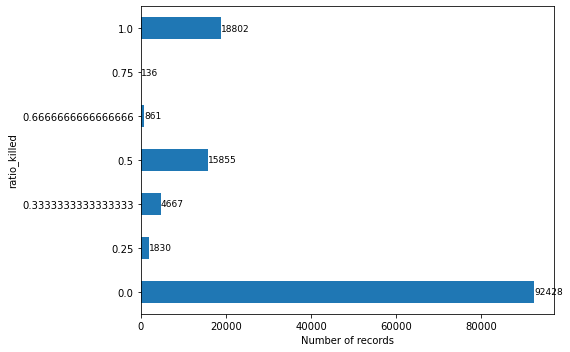

In [12]:
import matplotlib.pyplot as plt

# Grouping and counting values
counts = df_merged.groupby('ratio_killed').size()

# Creating the bar plot with tight layout
fig, ax = plt.subplots(figsize=(8, 5))
bars = counts.plot(kind='barh', ax=ax, rot=0)

# Annotating each bar with its count
for i, count in enumerate(counts):
    plt.text(count, i, str(count), ha='left', va='center', fontsize=9)

# Adding x-axis label
plt.xlabel('Number of records')

# Adjusting layout to make it more compact
plt.tight_layout()

plt.show()


In [13]:
# Discretize by gathering the n_killed_per_participants into 3 categories as we discussed
# If ration is [0,0.1), then label is 'No deaths', if ratio is [0.1, 0.75), then label is 'Some deaths', if ratio is [0.75, 1], then label is 'All deaths'

ratios = {'No deaths': [0, 0.1], 'Some deaths': [0.1, 0.75], 'All deaths': [0.75, 1]}

# map to n_killed_per_participant
df_merged['death_level'] = df_merged['ratio_killed'].map(
    lambda x: 'No deaths' if x >= ratios['No deaths'][0] and x < ratios['No deaths'][1] else 
    ('Some deaths' if x >= ratios['Some deaths'][0] and x < ratios['Some deaths'][1] else 'All deaths'))


<AxesSubplot:ylabel='death_level'>

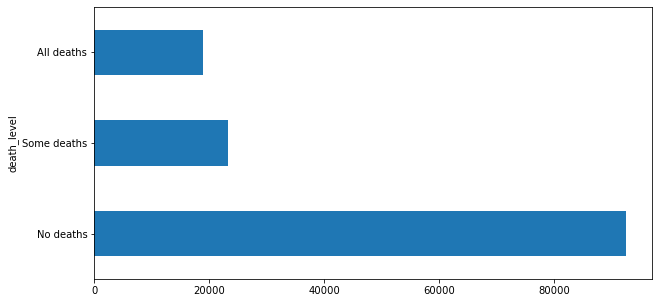

In [14]:
#df_merged.head()
# order the categories from 'No deaths' to 'All deaths'
df_merged['death_level'] = pd.Categorical(df_merged['death_level'], 
                    categories=['No deaths', 'Some deaths', 'All deaths'], 
                                                       ordered=True)

# Barplot after discretization
df_merged.groupby('death_level').size().plot(kind='barh', figsize=(10, 5), rot=0)

## 3. How many injured and killed people have been involved w.r.t the total injured and killed people in the same STATE during 2016 - 2018

In [15]:
df_merged_incident_poverty = df_merged.copy()

desired_years = [2016, 2017, 2018]



df_filtered = df_merged_incident_poverty[df_merged_incident_poverty['year'].isin(desired_years)]
# Group by congressional district
grouped_district = df_filtered.groupby('state')


#number of injured for each district
total_injured_district = df_merged_incident_poverty.groupby('state')['n_injured'].sum().reset_index()

#number of killed for each district
total_killed_district = df_merged_incident_poverty.groupby('state')['n_killed'].sum().reset_index()

# Calculate the total number of killed and injured people for each district
total_killed_injured = grouped_district[['n_killed', 'n_injured']].sum().reset_index()

# Calculate the total number of injured people relative to the total of injured and killed for each district
total_killed_injured['percentage_injured'] = (total_killed_injured['n_injured'] / (total_killed_injured['n_killed'] + total_killed_injured['n_injured'])) * 100

# Remove this since they are inversely correlated (-1)

# Calculate the total number of injured people relative to the total of injured and killed for each district
total_killed_injured['percentage_killed'] = (total_killed_injured['n_killed'] / (total_killed_injured['n_killed'] + total_killed_injured['n_injured'])) * 100

# Drop the n_killed and n_injured columns as are useless and duplicated
total_killed_injured.drop(['n_killed', 'n_injured'], axis=1, inplace=True)

# Merge the total_killed_injured DataFrame with the total_killed_district DataFrame



df_merged = pd.merge(df_merged, total_killed_injured, on=['state'], how='left')




In [16]:
df_merged.head()


date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage       party  candidatevotes  totalvotes  \
0  2014               16.8  REPUBLICAN        110789.0    206131.0   
1  2014               14.5  REPUBLICAN        100317.0    134043.0   
2  2014               10.1    DEMOCRAT        143431.0    273329.0   
3  2014               13.4    DEMOCRAT         70997.0    101606.0   
4  2014               10.2  REPUBLICAN        163011.0    281141.0   

   male_indicator  ratio_killed death_level  percentage_injured  \
0            3.00           0.0   No deaths           58.789954   
1            4.50           0.0   No deaths           45.310907   
2            2.25           0.0   No deaths           71.662763   
3            1.50           0.0   No deaths           70.237122   
4            3.00           1.0  All deaths           43.229167   

   percentage_killed  
0          41.210046  
1          54.689093  
2          28.337237  
3          29.762878  
4          56.770833

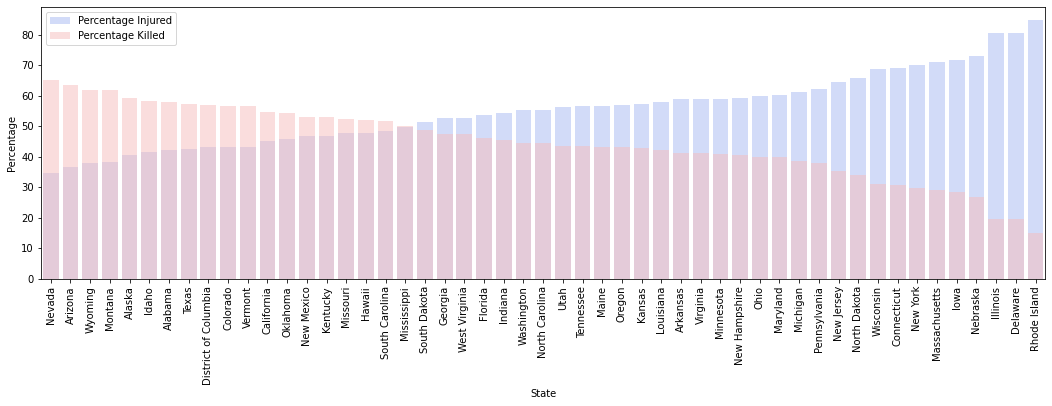

In [17]:
# Plot for combined percentage of killed and injured people
plt.figure(figsize=(18, 5))

# Order by percentage of killed people
total_killed_injured = total_killed_injured.sort_values(by='percentage_killed', ascending=False)

# Plotting killed percentage
# Plotting injured percentage
sns.barplot(x='state', y='percentage_injured', data=total_killed_injured, color='#99b3ff', label='Percentage Injured', alpha = 0.5)
sns.barplot(x='state', y='percentage_killed', data=total_killed_injured, color='#ffb3b3', label='Percentage Killed' , alpha = 0.5)
#plt.title('Combined Percentage of KILLED and INJURED People in each state (2016-2018) wrt killed and injured')
plt.xlabel('State')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.legend()

plt.show()

del [[total_killed_injured]]


## 4. *Ratio of unharmed people in the incident w.r.t. the average of unharmed people involved in incidents for the same period*

Due to dataframe dimension we computed the fourth index in another Notebook to avoid kernel panic. 

We save the result and retrieve the aggregated dataset from the file `index_4_cleaned.csv` to join the new indicator with the already computed in DF `df_merged`.

In [18]:
df_merged_unharmed = pd.read_csv('../../ds/cleaned/index_4_cleaned.csv')

# groupby year
df_merged_unharmed = df_merged_unharmed.groupby('year')['unharmed_ratio'].mean().reset_index()


Another visualization is by using the bar chart:

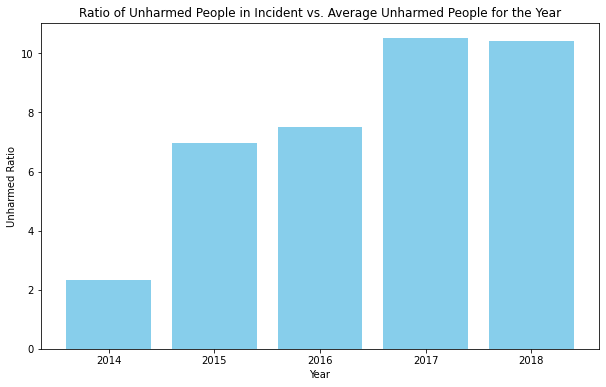

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(df_merged_unharmed['year'], df_merged_unharmed['unharmed_ratio'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Unharmed Ratio')
plt.title('Ratio of Unharmed People in Incident vs. Average Unharmed People for the Year')
plt.show()


df_merged = pd.merge(df_merged, df_merged_unharmed, on=['year'], how='left')


In [20]:
df_merged['unharmed_ratio'].count()


134579

In [21]:
df_merged['unharmed_ratio'].describe()


count    134579.000000
mean          7.304374
std           2.865222
min           2.345189
25%           6.948837
50%           7.498870
75%          10.512655
max          10.512655
Name: unharmed_ratio, dtype: float64

In [22]:
# Finding the row with the highest unharmed_ratio
max_unharmed_ratio = df_merged.loc[df_merged['unharmed_ratio'].idxmax()]

# Finding the row with the lowest unharmed_ratio
min_unharmed_ratio = df_merged.loc[df_merged['unharmed_ratio'].idxmin()]

# Calculating the average unharmed_ratio
avg_unharmed_ratio = df_merged['unharmed_ratio'].mean()

print("City/State/Year with the highest unharmed_ratio:")
print(max_unharmed_ratio[['city_or_county', 'state', 'year', 'unharmed_ratio']])

print("\nCity/State/Year with the lowest unharmed_ratio:")
print(min_unharmed_ratio[['city_or_county', 'state', 'year', 'unharmed_ratio']])

print("\nAverage unharmed_ratio across all incidents:")
print(avg_unharmed_ratio)


City/State/Year with the highest unharmed_ratio:
city_or_county      Chicago
state              Illinois
year                   2017
unharmed_ratio    10.512655
Name: 91385, dtype: object

City/State/Year with the lowest unharmed_ratio:
city_or_county    Pine Bluff
state               Arkansas
year                    2014
unharmed_ratio      2.345189
Name: 0, dtype: object

Average unharmed_ratio across all incidents:
7.304373963369842


In [23]:
df_merged.columns

Index(['date', 'state', 'city_or_county', 'latitude', 'longitude',
       'congressional_district', 'participant_age1', 'participant_age_group1',
       'participant_gender1', 'avg_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants',
       'incident_characteristics1', 'year', 'povertyPercentage', 'party',
       'candidatevotes', 'totalvotes', 'male_indicator', 'ratio_killed',
       'death_level', 'percentage_injured', 'percentage_killed',
       'unharmed_ratio'],
      dtype='object')

# Our indicators

## 5. *Number of incident density per state*

Let visualize with the map and the density of incidents per state.

In [24]:
import plotly.graph_objs as go

# density of incident per state

# Densities are n_participants in that state divided by the total number of participants in the dataset
densities = df_merged.groupby('state')['n_participants'].sum()/ df_merged['n_participants'].sum()

# normalize densities using min-max normalization
densities = (densities - densities.min()) / (densities.max() - densities.min())

# order by density
densities = densities.sort_values()

# plot a bar plot

data = [go.Bar(
            x=densities.index, # assign x as the dataframe column 'x'
            y=densities.values
    )]  

layout = go.Layout(
    yaxis=dict(title='Density of Incidents')
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# add this as index to the dataframe
df_merged['density_incident_state'] = df_merged['state'].map(densities)


In [25]:
df_merged.head()

date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage       party  candidatevotes  totalvotes  \
0  2014               16.8  REPUBLICAN        110789.0    206131.0   
1  2014               14.5  REPUBLICAN        100317.0    134043.0   
2  2014               10.1    DEMOCRAT        143431.0    273329.0   
3  2014               13.4    DEMOCRAT         70997.0    101606.0   
4  2014               10.2  REPUBLICAN        163011.0    281141.0   

   male_indicator  ratio_killed death_level  percentage_injured  \
0            3.00           0.0   No deaths           58.789954   
1            4.50           0.0   No deaths           45.310907   
2            2.25           0.0   No deaths           71.662763   
3            1.50           0.0   No deaths           70.237122   
4            3.00           1.0  All deaths           43.229167   

   percentage_killed  unharmed_ratio  density_incident_state  
0          41.210046        2.345189                0.136149  
1          54.689093        2.345189                0.639968  
2          28.337237        2.345189                0.096973  
3          29.762878        2.345189                0.534650  
4          56.770833        2.345189                0.097775

## 6. *Ratio males to females per incident*

This can arise some information with the other categorical variables.


In [26]:
# ratio males to females participants in each incident
# in order to get this ratio

df_merged['males_to_females_ratio'] = (df_merged['n_participants']-df_merged['n_females']) / df_merged['n_females'].replace(0, 1)

# count in how many incidents females are 0 in %
# take a row check if females are 0 and add 1 then sum all and divide by total number of rows
df_merged['males_to_females_ratio'].describe()


count    134579.000000
mean          1.514931
std           0.827585
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: males_to_females_ratio, dtype: float64

#### Females appears only in 20% of the incidents

In [27]:
# Calculate the number of rows where n_females is 0
num_zero_females = (df_merged['n_females'] == 0).sum()

# Calculate the total number of rows
total_rows = len(df_merged)

# Calculate the percentage
percentage_zero_females = (num_zero_females / total_rows) * 100
print(percentage_zero_females)

81.22589705674734


In [28]:
df_merged.head()


# This was saved for exporting clustering in a new file
# save dataframe csv

#df_merged.to_csv('../ds/cleaned/merged.csv', index=False)

date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  avg_age_participants  n_participants_child  \
0                Male                    26                     0   
1                Male                    28                     0   
2              Female                    35                     0   
3                Male                    29                     0   
4                Male                    47                     0   

   n_participants_teen  n_females  n_killed  n_injured  n_arrested  \
0                    0          0         0          1           0   
1                    0          0         0          2           0   
2                    0          2         0          1           0   
3                    0          1         0          3           0   
4                    0          0         1          0           0   

   n_unharmed  n_participants                  incident_characteristics1  \
0           1               2                     Shot - Wounded/Injured   
1           0               2                     Shot - Wounded/Injured   
2           1               2                                      other   
3           0               3                     Shot - Wounded/Injured   
4           0               1  Shot - Dead (murder, accidental, suicide)   

   year  povertyPercentage       party  candidatevotes  totalvotes  \
0  2014               16.8  REPUBLICAN        110789.0    206131.0   
1  2014               14.5  REPUBLICAN        100317.0    134043.0   
2  2014               10.1    DEMOCRAT        143431.0    273329.0   
3  2014               13.4    DEMOCRAT         70997.0    101606.0   
4  2014               10.2  REPUBLICAN        163011.0    281141.0   

   male_indicator  ratio_killed death_level  percentage_injured  \
0            3.00           0.0   No deaths           58.789954   
1            4.50           0.0   No deaths           45.310907   
2            2.25           0.0   No deaths           71.662763   
3            1.50           0.0   No deaths           70.237122   
4            3.00           1.0  All deaths           43.229167   

   percentage_killed  unharmed_ratio  density_incident_state  \
0          41.210046        2.345189                0.136149   
1          54.689093        2.345189                0.639968   
2          28.337237        2.345189                0.096973   
3          29.762878        2.345189                0.534650   
4          56.770833        2.345189                0.097775   

   males_to_females_ratio  
0                     2.0  
1                     2.0  
2                     0.0  
3                     2.0  
4                     1.0

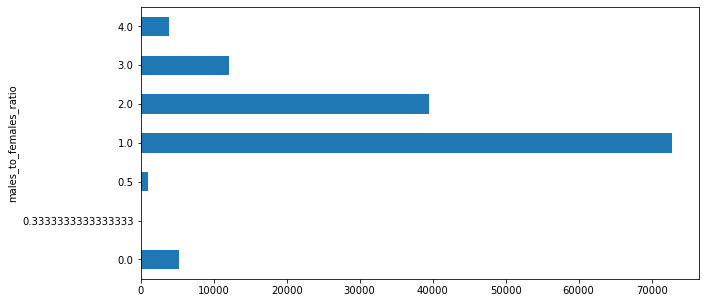

In [29]:
# Group by ratio male females and do barplot

df_merged.groupby('males_to_females_ratio')['participant_age_group1'].count().plot(kind='barh', figsize=(10, 5), rot=0) 

# We see very few incidents from 0 to 0.5, then a lot at 1, then half than the 1 for the ratio of 2, and so on until 4
# We can say that in half of incidents the ratio is 1 and in the rest more mens dies...

df_merged_pca = df_merged.copy()

In [30]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134579 entries, 0 to 134578
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       134579 non-null  datetime64[ns]
 1   state                      134579 non-null  object        
 2   city_or_county             134579 non-null  object        
 3   latitude                   134579 non-null  float64       
 4   longitude                  134579 non-null  float64       
 5   congressional_district     134579 non-null  int64         
 6   participant_age1           134579 non-null  int64         
 7   participant_age_group1     134579 non-null  category      
 8   participant_gender1        134579 non-null  category      
 9   avg_age_participants       134579 non-null  int64         
 10  n_participants_child       134579 non-null  int64         
 11  n_participants_teen        134579 non-null  int64   

# Preparing for last phase Correlation Analysis

In [31]:
# Check for head
df_merged.head()

# check for nan

# There are 639 male_indicator, drop them
df_merged.dropna(inplace=True)
# check for nan
df_merged.isnull().sum()


date                         0
state                        0
city_or_county               0
latitude                     0
longitude                    0
congressional_district       0
participant_age1             0
participant_age_group1       0
participant_gender1          0
avg_age_participants         0
n_participants_child         0
n_participants_teen          0
n_females                    0
n_killed                     0
n_injured                    0
n_arrested                   0
n_unharmed                   0
n_participants               0
incident_characteristics1    0
year                         0
povertyPercentage            0
party                        0
candidatevotes               0
totalvotes                   0
male_indicator               0
ratio_killed                 0
death_level                  0
percentage_injured           0
percentage_killed            0
unharmed_ratio               0
density_incident_state       0
males_to_females_ratio       0
dtype: i

In [32]:
len(df_merged.columns)

32

# Correlation matrix after adding the new features

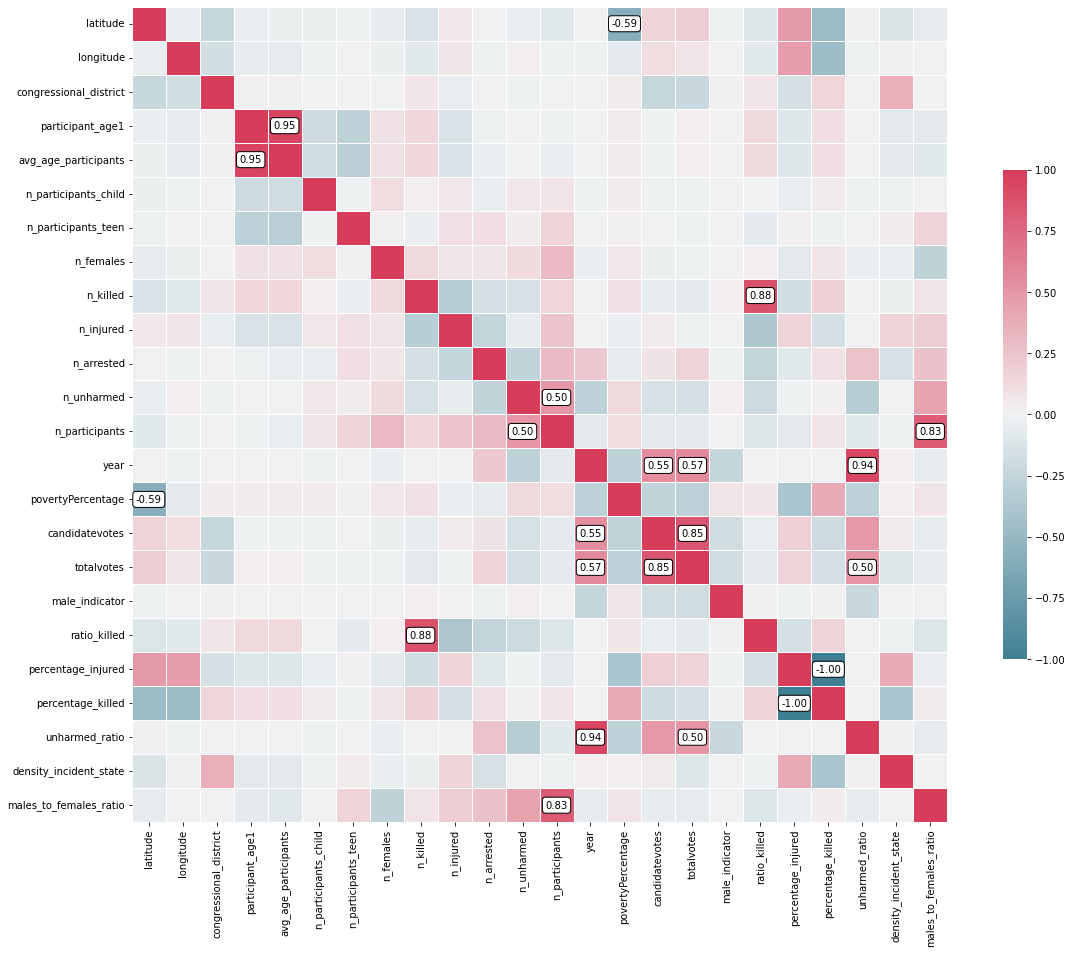

In [33]:

def plot_correlation(df_columns, df):
    
    # Compute the correlation matrix
    corr = df[df_columns].corr()

    # Generate a mask for the upper triangle
    #do not use np.bool is deprecated
    mask = np.zeros_like(corr, dtype=bool)
     
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 15))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 5, as_cmap=True)

    # Put numbers in squares that have correlation > 0.5 or < -0.5
    # Iterate over the correlation matrix and get the columns indices
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            if (corr.iloc[i, j] > 0.5 or corr.iloc[i, j] < -0.5) and i != j:
                # put text in square
                ax.text(j+0.5, i+0.5, '{:.2f}'.format(corr.iloc[i, j]), ha='center', va='center'
                        ,bbox=dict(boxstyle='round', facecolor='white', edgecolor='black')
                        )
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .6})
    #sns.heatmap(corr, annot=True)



plot_correlation(df_merged.select_dtypes(include=[np.number]).columns, df_merged)

# Dropping other variables

We again drop the features that we can see are higly correlated and we discussed in the report.

In [34]:
to_drop = ['participant_age1', 'year', 'n_killed', 'n_participants', 'totalvotes', 'percentage_killed']
# Use the function to drop highly correlated columns
df_merged.drop(to_drop, axis=1, inplace=True)

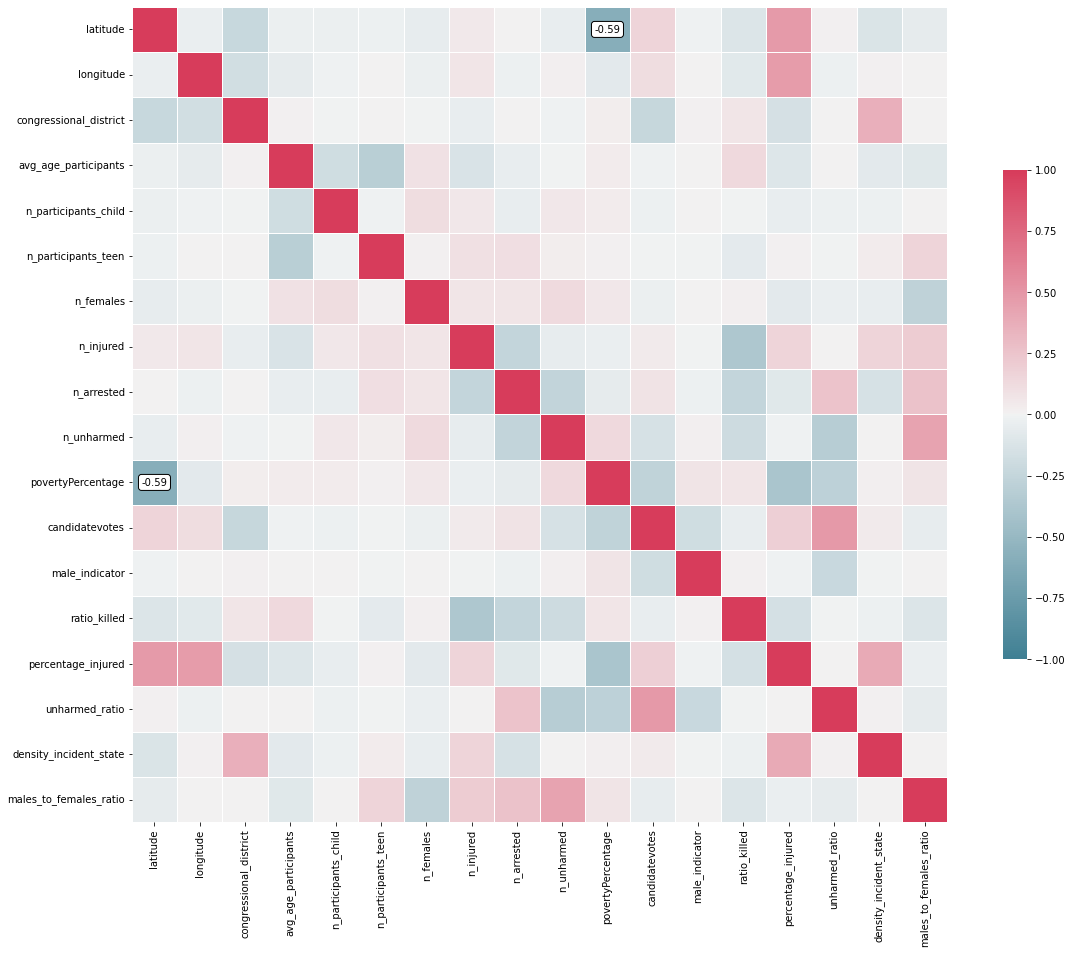

In [35]:
plot_correlation(df_merged.select_dtypes(include=[np.number]).columns, df_merged)

# Saving the dataset for the next task

In [41]:
# save this now in HDF5
df_merged_pca.to_hdf('../../ds/cleaned/reduced_for_clustering.h5', key = 'df', mode = 'w', format = 'table')

## More insights by Pairplot

Pairplot is very useful to see the correlation between variables by sampling from the data instead of just watching the correlation matrix numbers it show more information about the distribution of the variables, we also discussed this in the report.

These two pairplot contains information about variables that contains very few numbers in their distribution and usually are the number of unharmed, killed and so on...
We remove them in the final pairplot.


In [42]:
df_merged.columns

Index(['date', 'state', 'city_or_county', 'latitude', 'longitude',
       'congressional_district', 'participant_age1', 'participant_age_group1',
       'participant_gender1', 'avg_age_participants', 'n_participants_child',
       'n_participants_teen', 'n_females', 'n_killed', 'n_injured',
       'n_arrested', 'n_unharmed', 'n_participants',
       'incident_characteristics1', 'year', 'povertyPercentage', 'party',
       'candidatevotes', 'totalvotes', 'male_indicator', 'ratio_killed',
       'death_level', 'percentage_injured', 'percentage_killed',
       'unharmed_ratio', 'density_incident_state', 'males_to_females_ratio'],
      dtype='object')

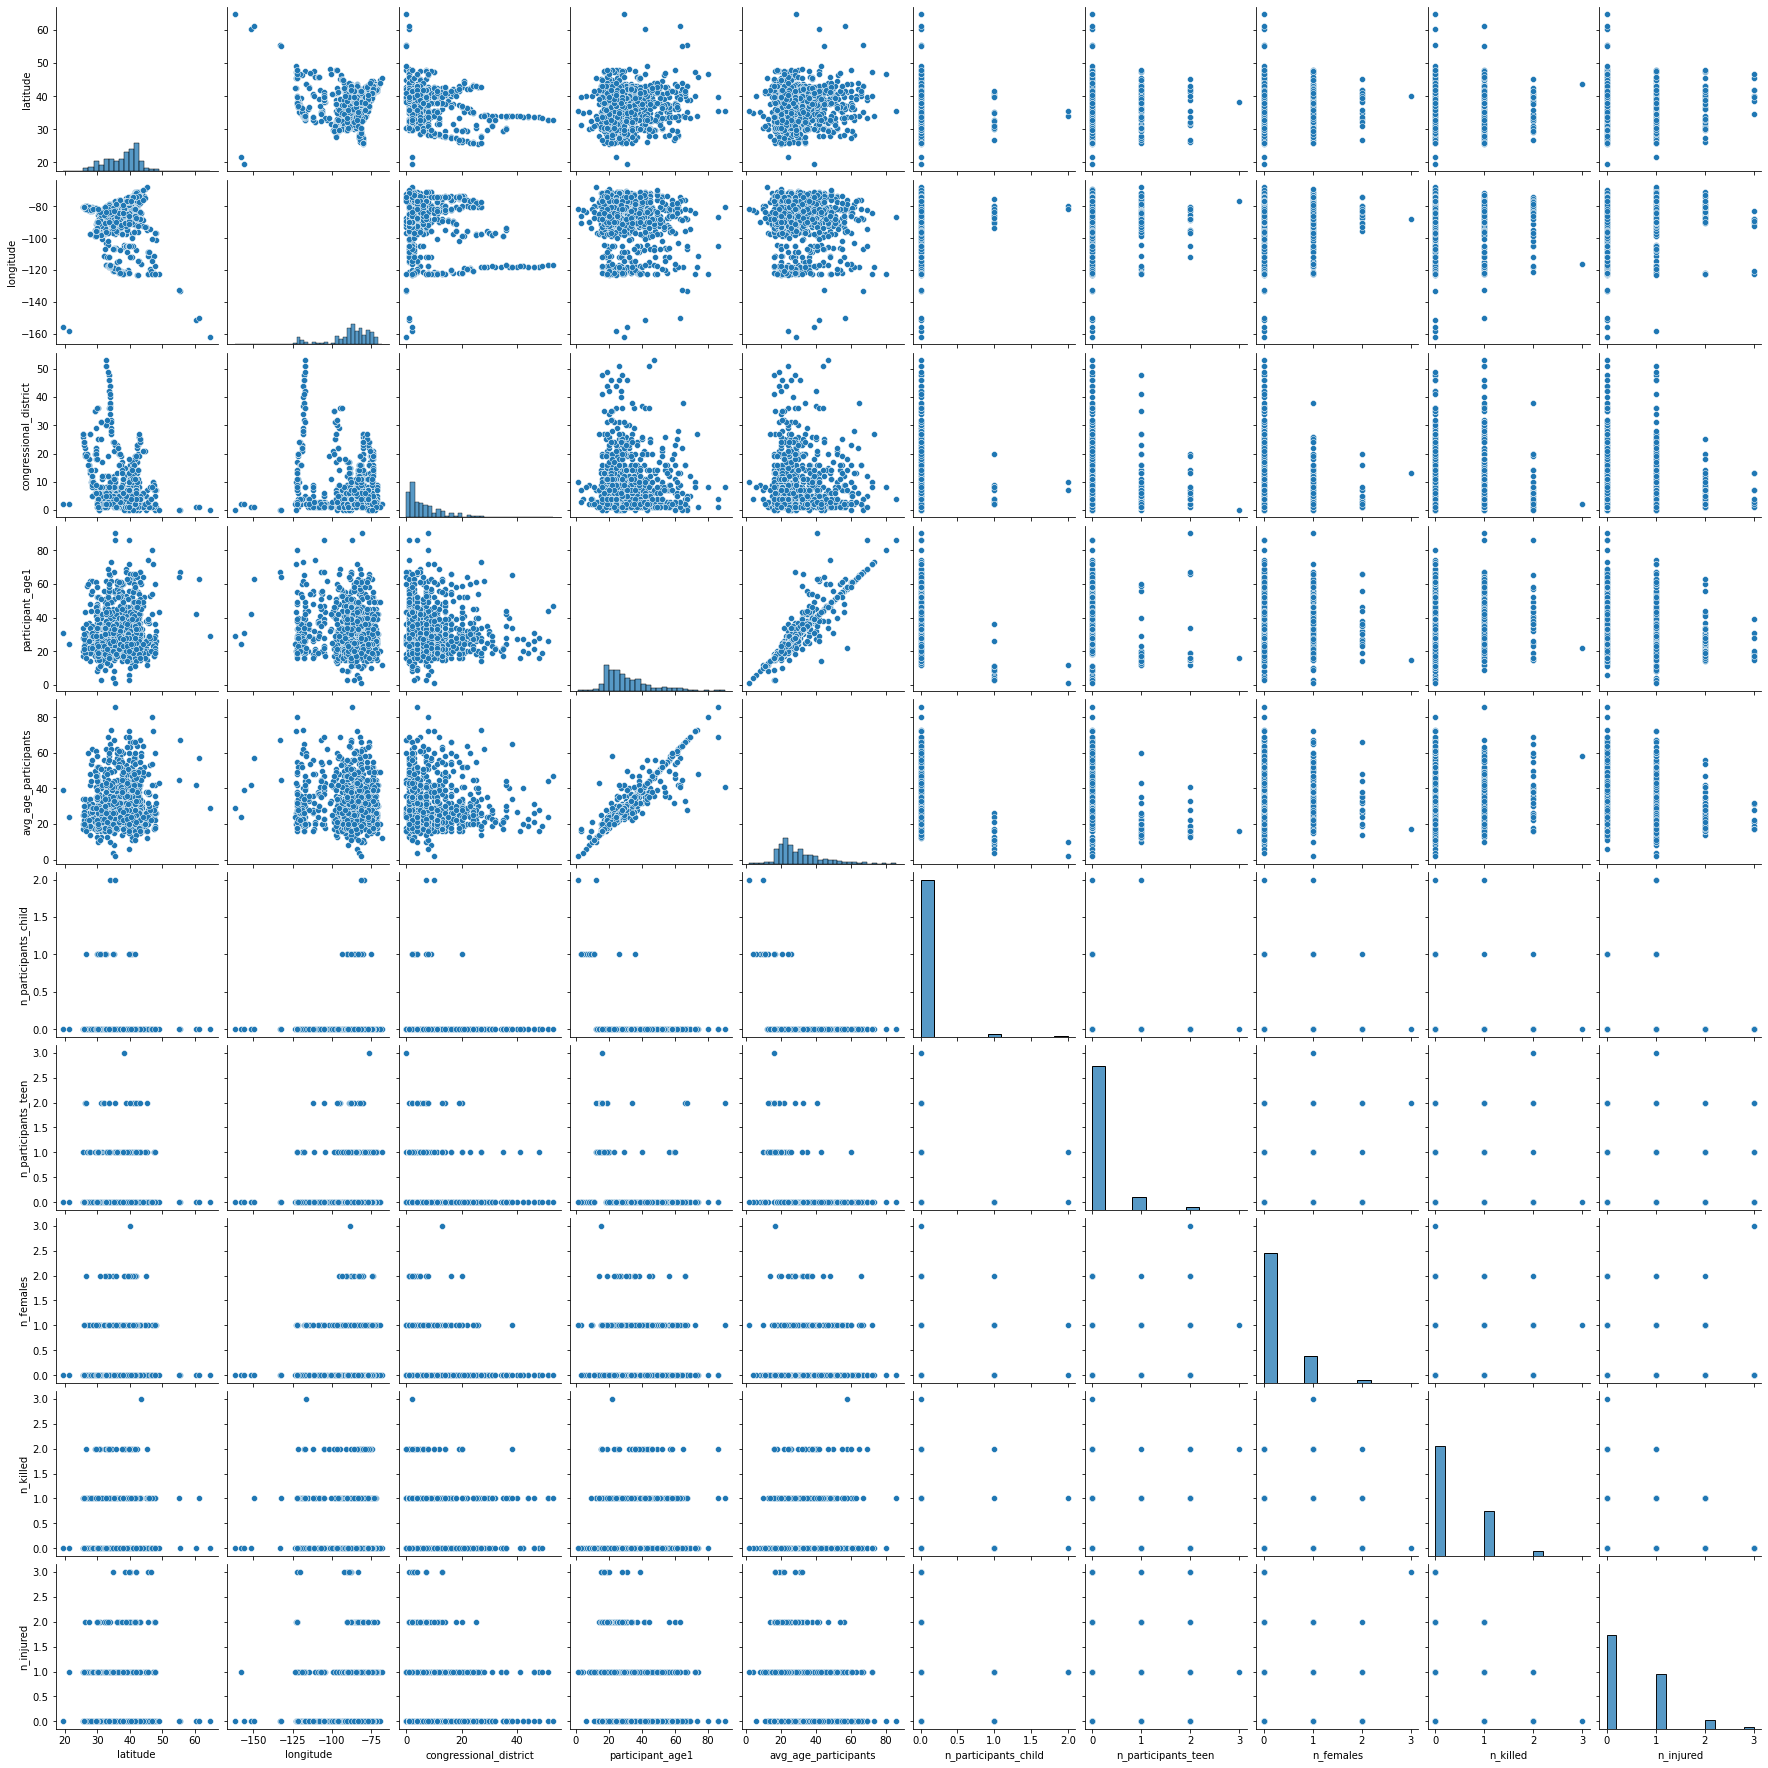

In [43]:
# pairplot only for numerical columns

# sample 1000 rows
df_merged_sample = df_merged.sample(1000)

# take first n numerical columns
numerical_columns = df_merged.select_dtypes(include=[np.number]).columns[:10]

# pairplot
sns.pairplot(df_merged_sample[numerical_columns])

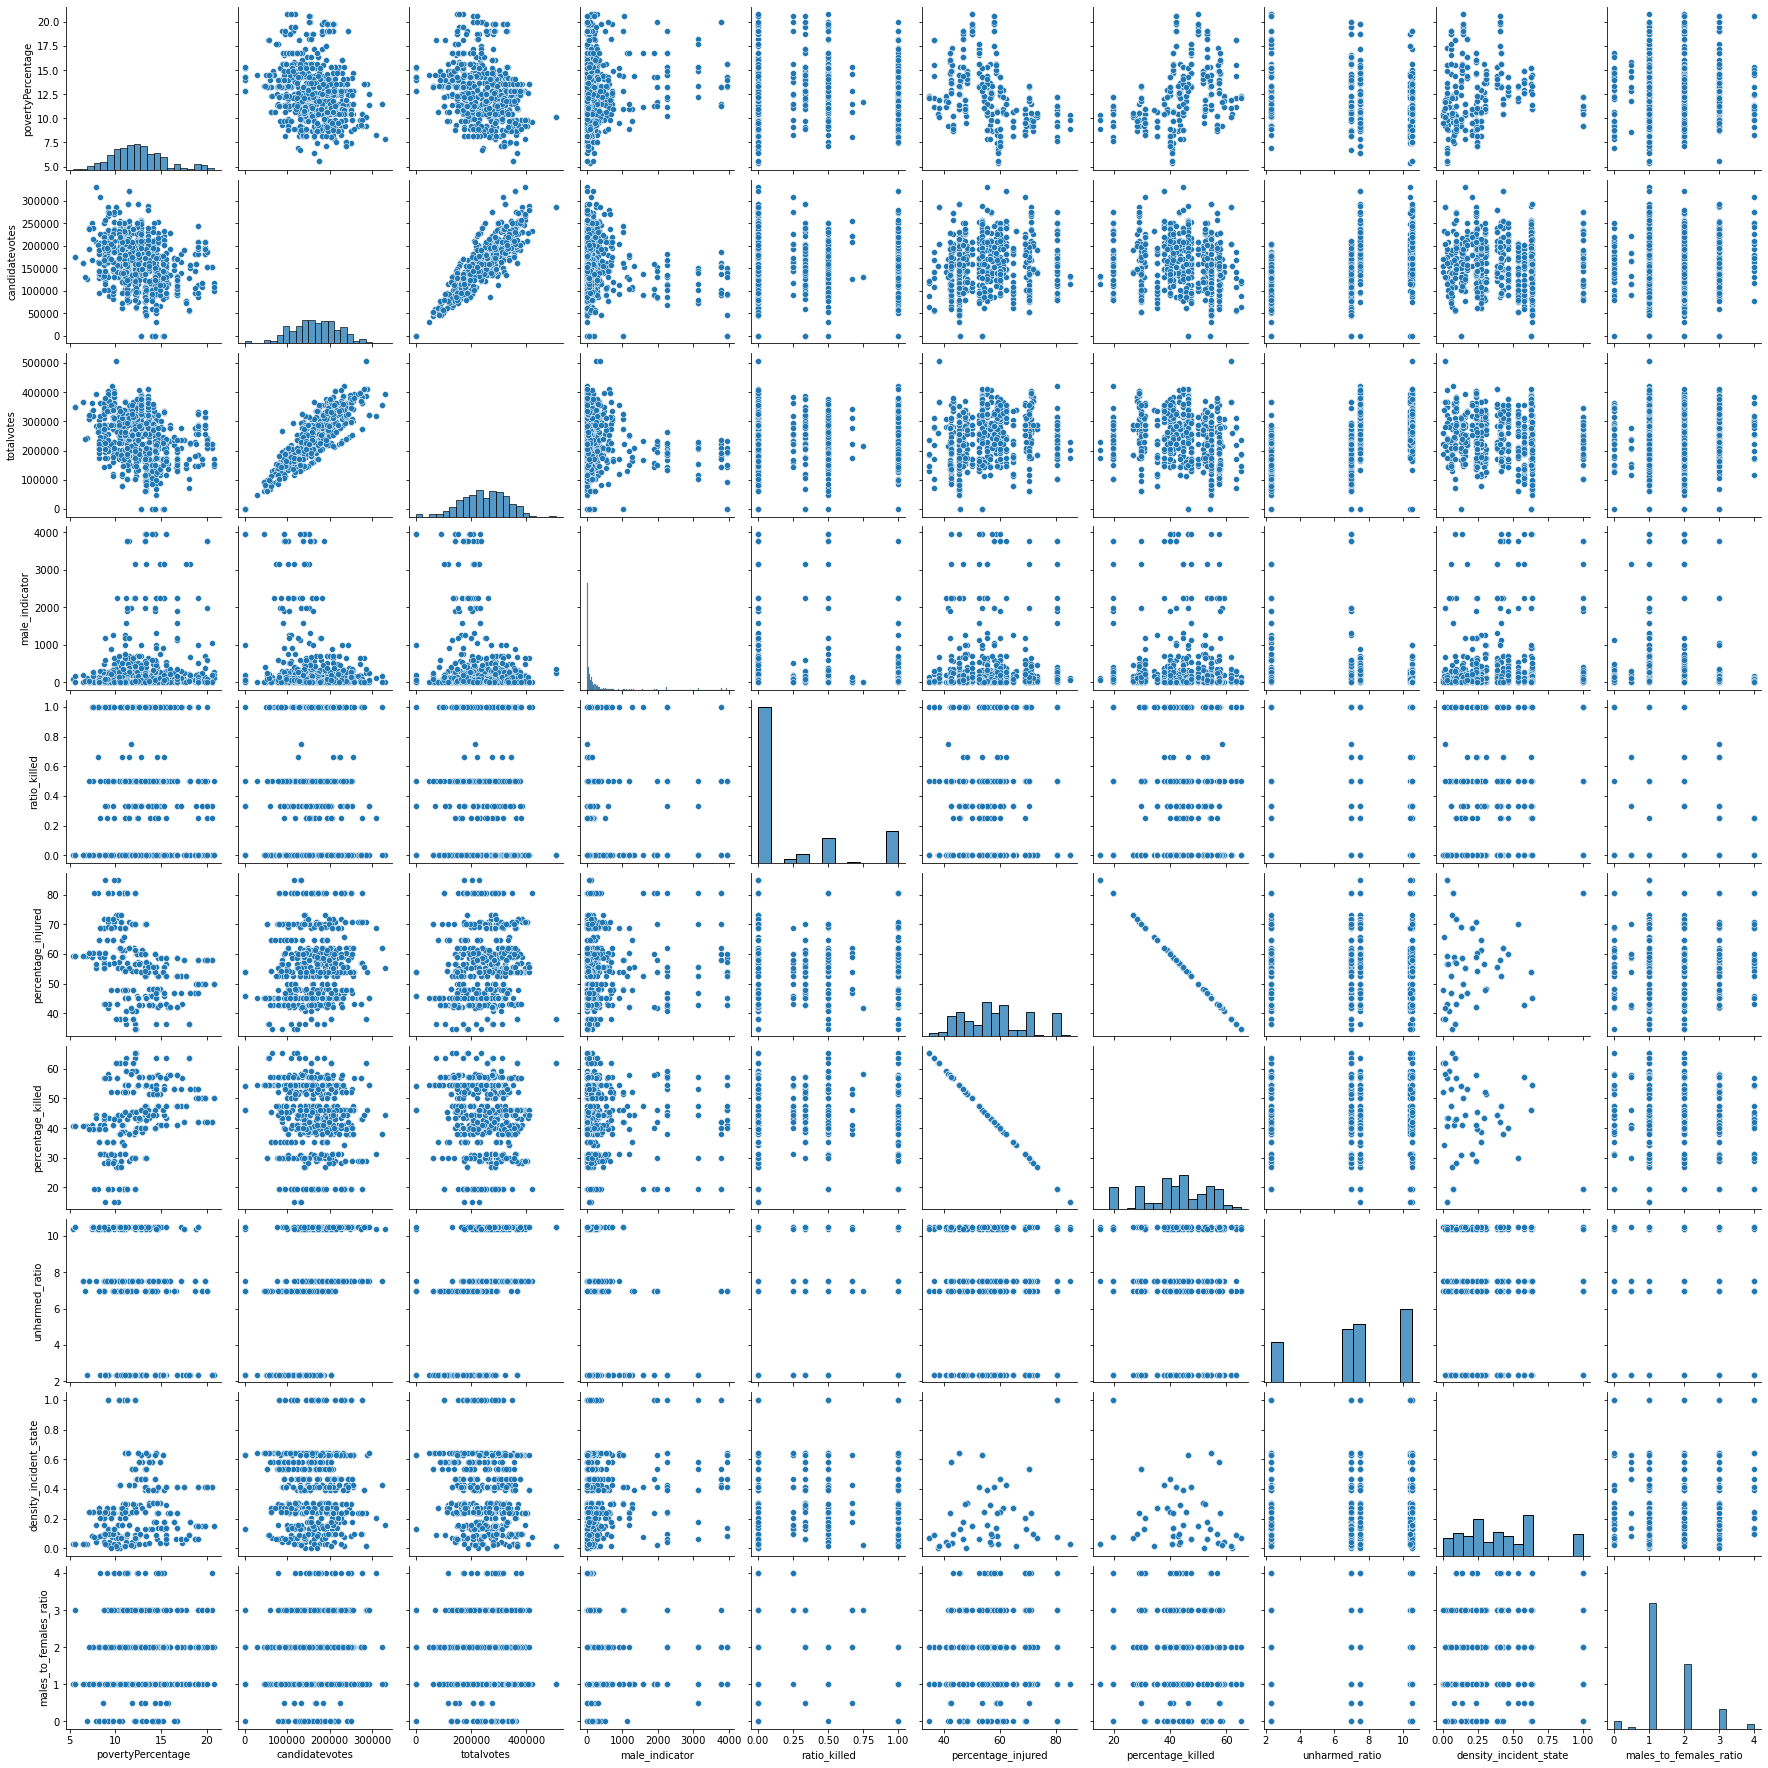

In [44]:
#take last n numerical columns
numerical_columns = df_merged.select_dtypes(include=[np.number]).columns[-10:]

#
# pairplot
sns.pairplot(df_merged_sample[numerical_columns])


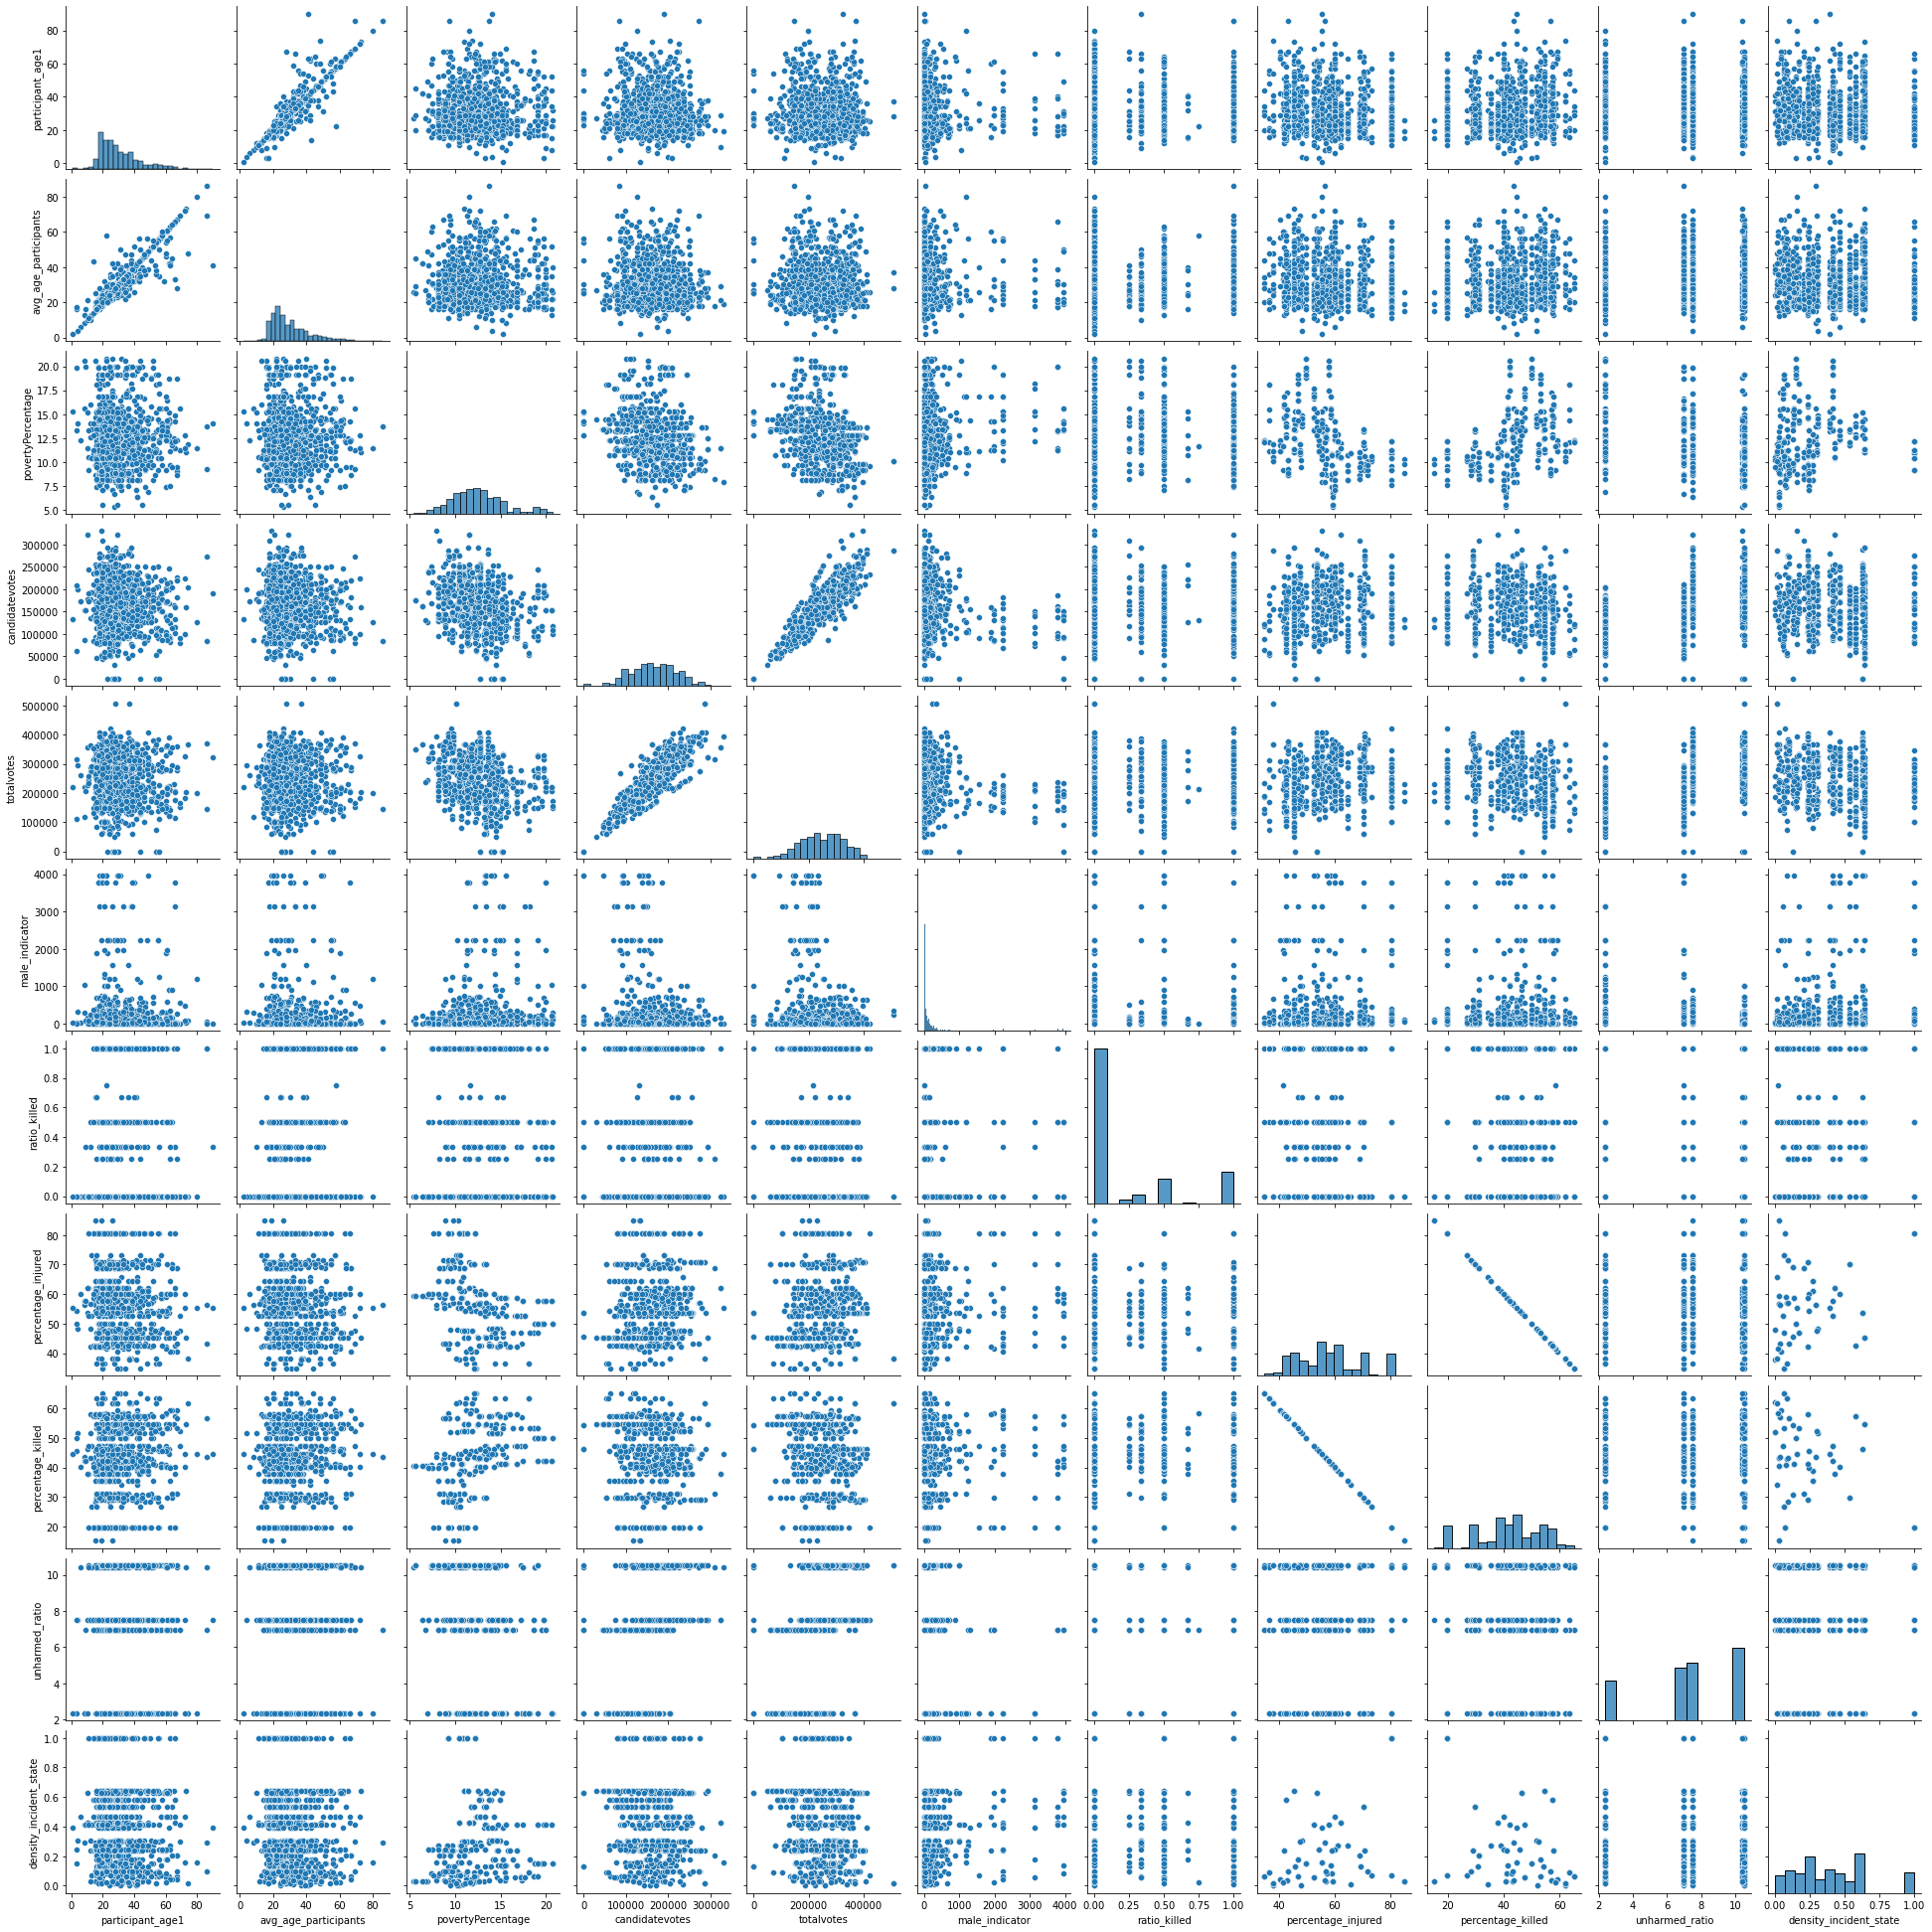

In [45]:
# We can see that intresting thing emerges when we exlude some of those columns so let's remove

# n_unharmed, year, n_participants, n_arrested, n_killed, n_females, n_participant_teen, n_participant_child

column_to_remove = ['n_injured','n_unharmed', 'year',
                    'n_participants', 'n_arrested', 'n_killed',
                    'n_females', 'n_participants_teen', 'n_participants_child',
                    'longitude', 'latitude', 'congressional_district', 'males_to_females_ratio']
# do pairplot without those columns
sns.pairplot(df_merged_sample.drop(column_to_remove, axis=1))

In [46]:
#Check None on df_merged_pca
df_merged_pca.isna().sum()


date                         0
state                        0
city_or_county               0
latitude                     0
longitude                    0
congressional_district       0
participant_age_group1       0
participant_gender1          0
avg_age_participants         0
n_participants_child         0
n_participants_teen          0
n_females                    0
n_injured                    0
n_arrested                   0
n_unharmed                   0
incident_characteristics1    0
povertyPercentage            0
party                        0
candidatevotes               0
male_indicator               0
ratio_killed                 0
death_level                  0
percentage_injured           0
unharmed_ratio               0
density_incident_state       0
males_to_females_ratio       0
dtype: int64